In [1]:
import pandas as pd
import os
import s3fs
import warnings
from datetime import date, timedelta, datetime
import numpy as np

exec(open('../0_KPI_functions.py').read())

In [2]:
# Ignore warning
warnings.filterwarnings('ignore')

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET = "bdc2324-data"
fs.ls(BUCKET)

['bdc2324-data/1',
 'bdc2324-data/10',
 'bdc2324-data/101',
 'bdc2324-data/11',
 'bdc2324-data/12',
 'bdc2324-data/13',
 'bdc2324-data/14',
 'bdc2324-data/2',
 'bdc2324-data/3',
 'bdc2324-data/4',
 'bdc2324-data/5',
 'bdc2324-data/6',
 'bdc2324-data/7',
 'bdc2324-data/8',
 'bdc2324-data/9']

## Look at the time sequence of each company and compute inter time coverage

In [73]:
sport = ['5', '6', '7', '8', '9']

In [90]:
def display_covering_time(df, company, datecover):
    """
    This function draws the time coverage of each company
    """
    min_date = df['purchase_date'].min().strftime("%Y-%m-%d")
    max_date = df['purchase_date'].max().strftime("%Y-%m-%d")
    datecover[company] = [datetime.strptime(min_date, "%Y-%m-%d") + timedelta(days=x) for x in range((datetime.strptime(max_date, "%Y-%m-%d") - datetime.strptime(min_date, "%Y-%m-%d")).days)]
    print(f'Couverture Company {company} : {min_date} - {max_date}')
    return datecover

In [91]:
def compute_time_intersection(datecover):
    timestamps_sets = [set(timestamps) for timestamps in datecover.values()]
    intersection = set.intersection(*timestamps_sets)
    intersection_list = list(intersection)
    formated_dates = [dt.strftime("%Y-%m-%d") for dt in intersection_list]
    return sorted(formated_dates)

In [93]:
def df_coverage_modelization(sport, coverage_train = 0.7):
    """
    This function returns start_date, end_of_features and final dates
    that help to construct train and test datasets
    """
    datecover = {}
    for company in sport:
        df_products_purchased_reduced = display_databases(company, file_name = "products_purchased_reduced",
                                                          datetime_col = ['purchase_date'])
        datecover = display_covering_time(df_products_purchased_reduced, company, datecover)
    #print(datecover.keys())
    dt_coverage = compute_time_intersection(datecover)
    start_date = dt_coverage[0]
    end_of_features = dt_coverage[int(0.7 * len(dt_coverage))]
    final_date = dt_coverage[-1]
    return start_date, end_of_features, final_date
    

In [94]:
start_date, end_of_features, final_date = df_coverage_modelization(sport, coverage_train = 0.7)
print(start_date, end_of_features, final_date )

File path :  projet-bdc2324-team1/0_Input/Company_5/products_purchased_reduced.csv
Couverture Company 5 : 2019-04-15 - 2023-11-09
File path :  projet-bdc2324-team1/0_Input/Company_6/products_purchased_reduced.csv
Couverture Company 6 : 2018-06-28 - 2023-11-08
File path :  projet-bdc2324-team1/0_Input/Company_7/products_purchased_reduced.csv
Couverture Company 7 : 2015-02-10 - 2023-11-08
File path :  projet-bdc2324-team1/0_Input/Company_8/products_purchased_reduced.csv
Couverture Company 8 : 2010-09-28 - 2023-11-08
File path :  projet-bdc2324-team1/0_Input/Company_9/products_purchased_reduced.csv
Couverture Company 9 : 2014-09-22 - 2023-10-24
dict_keys(['5', '6', '7', '8', '9'])
2019-04-15 2022-06-15 2023-10-23


## Look at common database between Sport companies

In [101]:
companies = fs.ls(BUCKET)
companies = [company for company in companies if any(company.endswith(end) for end in sport)]
companies

['bdc2324-data/5',
 'bdc2324-data/6',
 'bdc2324-data/7',
 'bdc2324-data/8',
 'bdc2324-data/9']

In [107]:
companies_database = {}

for company in companies:
    companies_database[company.split('/')[-1]] = [file.split('/')[-1].replace(company.split('/')[-1], '') for file in fs.ls(company)] 

all_database = companies_database[max(companies_database, key=lambda x: len(companies_database[x]))]
print("Number of databases : ",len(all_database))

data_in_common = set(all_database)

for key in companies_database:
    diff_database = data_in_common.symmetric_difference(companies_database[key])
    data_in_common = data_in_common - diff_database

print("Number of common databases : ",len(data_in_common))

Number of databases :  30
Number of common databases :  23


In [121]:
data_in_common

{'campaign_stats.csv',
 'campaigns.csv',
 'categories.csv',
 'countries.csv',
 'currencies.csv',
 'customer_target_mappings.csv',
 'customersplus.csv',
 'event_types.csv',
 'events.csv',
 'facilities.csv',
 'link_stats.csv',
 'pricing_formulas.csv',
 'product_packs.csv',
 'products.csv',
 'products_groups.csv',
 'purchases.csv',
 'representation_category_capacities.csv',
 'representations.csv',
 'seasons.csv',
 'suppliers.csv',
 'target_types.csv',
 'targets.csv',
 'tickets.csv'}

## Investigate errors from data construction for company 6

In [108]:
directory_path = '6'

In [143]:
df_customerplus_clean = display_databases(directory_path, file_name = "customerplus_cleaned")
df_campaigns_information = display_databases(directory_path, file_name = "campaigns_information", datetime_col = ['opened_at', 'sent_at', 'campaign_sent_at'])
df_products_purchased_reduced = display_databases(directory_path, file_name = "products_purchased_reduced", datetime_col = ['purchase_date'])

File path :  projet-bdc2324-team1/0_Input/Company_6/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/products_purchased_reduced.csv


In [144]:
max_date =  pd.to_datetime(final_date, utc = True, format = 'ISO8601') 
end_features_date = pd.to_datetime(end_of_features, utc = True, format = 'ISO8601')
min_date = pd.to_datetime(start_date, utc = True, format = 'ISO8601')

In [128]:
df_campaigns_information = display_databases(directory_path, file_name = "campaigns_information", datetime_col = ['opened_at', 'sent_at', 'campaign_sent_at'])

File path :  projet-bdc2324-team1/0_Input/Company_6/campaigns_information.csv


In [133]:
end_features_date

Timestamp('2022-06-15 00:00:00+0000', tz='UTC')

In [136]:
print("Shape campaigns_information : ", df_campaigns_information.shape)
df_campaigns_information.head()

Shape campaigns_information :  (1333010, 8)


id  customer_id opened_at                   sent_at delivered_at  \
0   1           38       NaT 2022-08-02 18:31:33+00:00          NaN   
1   2        26135       NaT 2022-08-02 18:31:34+00:00          NaN   
2   3         3876       NaT 2022-08-02 18:31:35+00:00          NaN   
3   4        26226       NaT 2022-08-02 18:31:35+00:00          NaN   
4   5        25349       NaT 2022-08-02 18:31:34+00:00          NaN   

              campaign_name  campaign_service_id          campaign_sent_at  
0  Adhérents non ré-engagés                   15 2022-08-02 18:31:36+00:00  
1  Adhérents non ré-engagés                   15 2022-08-02 18:31:36+00:00  
2  Adhérents non ré-engagés                   15 2022-08-02 18:31:36+00:00  
3  Adhérents non ré-engagés                   15 2022-08-02 18:31:36+00:00  
4  Adhérents non ré-engagés                   15 2022-08-02 18:31:36+00:00

In [134]:
df_campaigns_information['sent_at'].min()

Timestamp('2022-08-02 18:31:33+0000', tz='UTC')

In [137]:
df_campaigns_information['sent_at'].max()

Timestamp('2023-11-07 10:08:16+0000', tz='UTC')

In [127]:
#Filtre de la base df_campaigns_information
df_campaigns_information = df_campaigns_information[(df_campaigns_information['sent_at'] <= end_features_date) & (df_campaigns_information['sent_at'] >= min_date)]
df_campaigns_information

Empty DataFrame
Columns: [id, customer_id, opened_at, sent_at, delivered_at, campaign_name, campaign_service_id, campaign_sent_at]
Index: []

In [145]:
#Filtre de la base df_products_purchased_reduced
df_products_purchased_reduced = df_products_purchased_reduced[(df_products_purchased_reduced['purchase_date'] <= end_features_date) & (df_products_purchased_reduced['purchase_date'] >= min_date)]
df_products_purchased_reduced.head()

ticket_id  customer_id  purchase_id  event_type_id   supplier_name  \
49       91401       108392    1259025.0              4          caisse   
117     535527        31304     136629.0              4        adhésion   
274     547400          192     140477.0              4        adhésion   
304      84413        31388      20259.0              4        adhésion   
311     407271         3265      90527.0              4  web [adhésion]   

                       purchase_date  amount  is_full_price  \
49  2022-02-27 13:44:10.690000+00:00     0.0          False   
117 2022-04-28 15:47:52.790000+00:00     0.0          False   
274 2022-04-28 15:47:54.053000+00:00     0.0          False   
304 2021-08-03 13:45:01.603000+00:00     0.0          False   
311 2022-05-26 09:15:40.993000+00:00     0.0          False   

      name_event_types  name_facilities  name_categories  \
49   ligue 1 uber eats  stade de l'aube    honneur basse   
117  ligue 1 uber eats  stade de l'aube    honneur basse   
274  ligue 1 uber eats  stade de l'aube    honneur basse   
304  ligue 1 uber eats  stade de l'aube     vitoux haute   
311  ligue 1 uber eats  stade de l'aube  champagne basse   

                name_events      name_seasons  
49   olympique de marseille  saison 2021-2022  
117              ac ajaccio  saison 2022-2023  
274           rc strasbourg  saison 2022-2023  
304  olympique de marseille  saison 2021-2022  
311       stade brestois 29  saison 2022-2023

In [150]:
df_products_purchased_reduced["supplier_name"].unique()

array(['caisse', 'adhésion', 'web [adhésion]', 'web [grand public]',
       'itr ticketmaster', 'itr fnac', nan, 'decathlon', 'boutique web',
       'boutique officielle'], dtype=object)

In [151]:
# KPI sur le comportement d'achat
tickets_information_copy = df_products_purchased_reduced.copy()
# Dummy : Canal de vente en ligne
liste_mots = ['en ligne', 'internet', 'web', 'net', 'vad', 'online'] # vad = vente à distance
tickets_information_copy['vente_internet'] = tickets_information_copy['supplier_name'].fillna('').str.contains('|'.join(liste_mots), case=False).astype(int)

tickets_information_copy['vente_internet'] corrected by handling na

## Investigate train and test

In [6]:
def display_databases(directory_path, file_name):
    """
    This function returns the file from s3 storage 
    """
    file_path = "projet-bdc2324-team1" + "/Generalization/" + directory_path + "/" + file_name + ".csv"
    print("File path : ", file_path)
    with fs.open(file_path, mode="rb") as file_in:
        df = pd.read_csv(file_in, sep=",")        
    return df  

In [11]:
train_sport = display_databases('sport', 'Train_set').fillna(0)
train_sport.head()

File path :  projet-bdc2324-team1/Generalization/sport/Train_set.csv


customer_id  nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0   5_6046652         0.0           0.0           0.0           0.0   
1   5_3789159         0.0           0.0           0.0           0.0   
2   5_5991148         0.0           0.0           0.0           0.0   
3   5_3848065         0.0           0.0           0.0           0.0   
4   5_6154495         0.0           0.0           0.0           0.0   

   vente_internet_max  purchase_date_min  purchase_date_max  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   time_between_purchase  nb_tickets_internet  ...  country  gender_label  \
0                    0.0                  0.0  ...       af         other   
1                    0.0                  0.0  ...       fr          male   
2                    0.0                  0.0  ...       af         other   
3                    0.0                  0.0  ...       fr          male   
4                    0.0                  0.0  ...       af         other   

   gender_female  gender_male  gender_other  country_fr  nb_campaigns  \
0              0            0             1         0.0           0.0   
1              0            1             0         1.0           0.0   
2              0            0             1         0.0           0.0   
3              0            1             0         1.0           0.0   
4              0            0             1         0.0           0.0   

   nb_campaigns_opened  time_to_open  y_has_purchased  
0                  0.0             0              0.0  
1                  0.0             0              0.0  
2                  0.0             0              0.0  
3                  0.0             0              0.0  
4                  0.0             0              0.0  

[5 rows x 40 columns]

In [10]:
print('shape : ', train_sport.shape) 
print('number of na explained variable : ', train_sport['y_has_purchased'].isna().sum())

shape :  (426449, 40)
number of na explained variable :  369102


<Axes: xlabel='y_has_purchased', ylabel='count'>

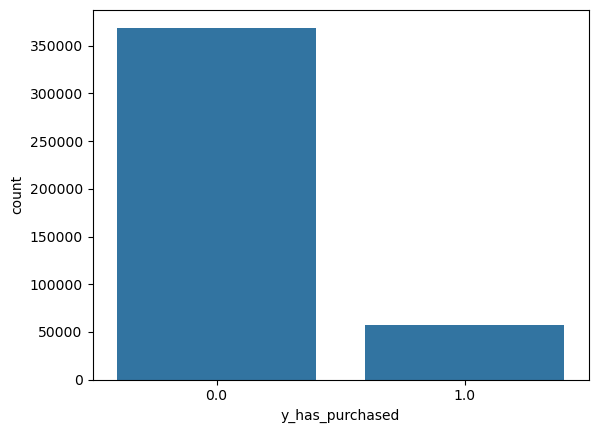

In [12]:
import seaborn as sns

sns.countplot(train_sport, x='y_has_purchased')

In [5]:
fs.ls('projet-bdc2324-team1/Generalization/sport')

['projet-bdc2324-team1/Generalization/sport/Test_set',
 'projet-bdc2324-team1/Generalization/sport/Test_set.csv',
 'projet-bdc2324-team1/Generalization/sport/Train_set',
 'projet-bdc2324-team1/Generalization/sport/Train_set.csv']

## Look at y_has_purchased

In [75]:
def display_databases(directory_path, file_name, datetime_col = None):
    """
    This function returns the file from s3 storage 
    """
    file_path = "projet-bdc2324-team1" + "/0_Input/Company_" + directory_path + "/" + file_name + ".csv"
    print("File path : ", file_path)
    with fs.open(file_path, mode="rb") as file_in:
        df = pd.read_csv(file_in, sep=",", parse_dates = datetime_col, date_parser=custom_date_parser)        
    return df 

In [76]:
directory_path = '5'
# start_date, end_of_features, final_date = df_coverage_modelization(list_of_comp, coverage_train = 0.7)
min_date = "2021-05-01"
end_features_date = "2022-11-01"
max_date = "2023-11-01"

In [60]:
df_customerplus_clean_0 = display_databases(directory_path, file_name = "customerplus_cleaned")
df_campaigns_information = display_databases(directory_path, file_name = "campaigns_information",
                                             datetime_col = ['opened_at', 'sent_at', 'campaign_sent_at'])
df_products_purchased_reduced = display_databases(directory_path, file_name = "products_purchased_reduced",
                                                  datetime_col = ['purchase_date'])

# Filtre de cohérence pour la mise en pratique de notre méthode
max_date =  pd.to_datetime(max_date, utc = True, format = 'ISO8601') 
end_features_date = pd.to_datetime(end_features_date, utc = True, format = 'ISO8601')
min_date = pd.to_datetime(min_date, utc = True, format = 'ISO8601')

df_campaigns_information = df_campaigns_information[(df_campaigns_information['sent_at'] <= end_features_date) & (df_campaigns_information['sent_at'] >= min_date)]
df_campaigns_information['opened_at'][df_campaigns_information['opened_at'] >= end_features_date] = np.datetime64('NaT')

#Filtre de la base df_products_purchased_reduced
df_products_purchased_reduced = df_products_purchased_reduced[(df_products_purchased_reduced['purchase_date'] <= end_features_date) & (df_products_purchased_reduced['purchase_date'] >= min_date)]




File path :  projet-bdc2324-team1/0_Input/Company_5/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/products_purchased_reduced.csv


In [61]:
df_campaigns_information.head()

Empty DataFrame
Columns: [id, customer_id, opened_at, sent_at, delivered_at, campaign_name, campaign_service_id, campaign_sent_at]
Index: []

In [62]:
df_products_purchased_reduced.head()

ticket_id  customer_id  purchase_id  event_type_id supplier_name  \
0    6287839       204007     545836.0            824           fov   
1    6287840       204007     545836.0            824           fov   
2    6154548       227006     535225.0            824           fov   
3    6154549       227006     535225.0            824           fov   
4    6287843       407930     545838.0            824           fov   

              purchase_date  amount  is_full_price name_event_types  \
0 2022-03-31 03:42:59+00:00    55.0          False      match rugby   
1 2022-03-31 03:42:59+00:00    30.0          False      match rugby   
2 2022-02-28 16:31:29+00:00    55.0          False      match rugby   
3 2022-02-28 16:31:29+00:00    55.0          False      match rugby   
4 2022-03-31 04:00:22+00:00    55.0          False      match rugby   

  name_facilities name_categories                  name_events  \
0      jean bouin        centrale  sf paris / racing 92 (ercc)   
1      jean bouin        centrale  sf paris / racing 92 (ercc)   
2      jean bouin        centrale  sf paris / racing 92 (ercc)   
3      jean bouin        centrale  sf paris / racing 92 (ercc)   
4      jean bouin        centrale  sf paris / racing 92 (ercc)   

         name_seasons            start_date_time              end_date_time  \
0  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
1  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
2  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
3  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
4  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   

   open  
0  True  
1  True  
2  True  
3  True  
4  True

In [63]:
# Fusion de l'ensemble et creation des KPI

# KPI sur les campagnes publicitaires
df_campaigns_kpi = campaigns_kpi_function(campaigns_information = df_campaigns_information) 

# KPI sur le comportement d'achat
df_tickets_kpi = tickets_kpi_function(tickets_information = df_products_purchased_reduced)

# KPI sur les données socio-démographiques
df_customerplus_clean = customerplus_kpi_function(customerplus_clean = df_customerplus_clean_0)

In [65]:
# Fusion avec KPI liés au customer
df_customer = pd.merge(df_customerplus_clean, df_campaigns_kpi, on = 'customer_id', how = 'left')
df_customer.head()

customer_id  street_id  structure_id  mcp_contact_id  fidelity  tenant_id  \
0      6009745    1372685           NaN             NaN         0       1771   
1      6011228    1372685           NaN             NaN         0       1771   
2      6058950    1372685           NaN             NaN         0       1771   
3      6062404    1372685           NaN             NaN         0       1771   
4       250217      78785           NaN         11035.0         0       1771   

   is_partner  deleted_at  gender  is_email_true  ...  first_buying_date  \
0       False         NaN       2           True  ...                NaN   
1       False         NaN       2           True  ...                NaN   
2       False         NaN       2           True  ...                NaN   
3       False         NaN       2           True  ...                NaN   
4       False         NaN       0           True  ...                NaN   

  country  gender_label  gender_female  gender_male  gender_other  country_fr  \
0      af         other              0            0             1         0.0   
1      af         other              0            0             1         0.0   
2      af         other              0            0             1         0.0   
3      af         other              0            0             1         0.0   
4      fr        female              1            0             0         1.0   

   nb_campaigns  nb_campaigns_opened  time_to_open  
0           NaN                  NaN           NaT  
1           NaN                  NaN           NaT  
2           NaN                  NaN           NaT  
3           NaN                  NaN           NaT  
4           NaN                  NaN           NaT  

[5 rows x 30 columns]

In [66]:
df_customer[['nb_campaigns', 'nb_campaigns_opened']] = df_customer[['nb_campaigns', 'nb_campaigns_opened']].fillna(0)
# Fusion avec KPI liés au comportement d'achat
df_customer_product = pd.merge(df_tickets_kpi, df_customer, on = 'customer_id', how = 'outer')
df_customer_product.head()

customer_id  nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0       160516       149.0           3.0        4470.0           1.0   
1       160517      1977.0          27.0        1473.0           2.0   
2       160518       116.0           8.0         439.0           2.0   
3       160519        34.0           2.0         608.0           1.0   
4       160520       207.0           5.0           0.0           1.0   

   vente_internet_max  purchase_date_min  purchase_date_max  \
0                 0.0         409.693137          66.356979   
1                 1.0         431.558519          27.733472   
2                 0.0         427.177720          23.689340   
3                 0.0         483.642940         108.777870   
4                 0.0         431.550012          69.310266   

   time_between_purchase  nb_tickets_internet  ...          first_buying_date  \
0             343.336157                  0.0  ...  2021-09-17 06:39:19+00:00   
1             403.825046                 15.0  ...  2021-08-26 09:53:10+00:00   
2             403.488380                  0.0  ...  2021-08-30 19:01:31+00:00   
3             374.865069                  0.0  ...  2019-05-21 08:03:52+00:00   
4             362.239745                  0.0  ...  2019-08-20 15:10:07+00:00   

   country  gender_label  gender_female  gender_male  gender_other  \
0       fr          male              0            1             0   
1       fr        female              1            0             0   
2       fr          male              0            1             0   
3       fr        female              1            0             0   
4       fr          male              0            1             0   

   country_fr  nb_campaigns  nb_campaigns_opened  time_to_open  
0         1.0           0.0                  0.0           NaT  
1         1.0           0.0                  0.0           NaT  
2         1.0           0.0                  0.0           NaT  
3         1.0           0.0                  0.0           NaT  
4         1.0           0.0                  0.0           NaT  

[5 rows x 39 columns]

In [67]:
# Fill NaN values
df_customer_product[['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'nb_tickets_internet']] = df_customer_product[['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'nb_tickets_internet']].fillna(0)

# 2. Construction of the explained variable 
df_products_purchased_to_predict = df_products_purchased_reduced[(df_products_purchased_reduced['purchase_date'] <= max_date) & (df_products_purchased_reduced['purchase_date'] > end_features_date)]
df_products_purchased_to_predict.head()


Empty DataFrame
Columns: [ticket_id, customer_id, purchase_id, event_type_id, supplier_name, purchase_date, amount, is_full_price, name_event_types, name_facilities, name_categories, name_events, name_seasons, start_date_time, end_date_time, open]
Index: []

In [68]:
df_products_purchased_reduced['purchase_date'].unique()

<DatetimeArray>
['2022-03-31 03:42:59+00:00', '2022-02-28 16:31:29+00:00',
 '2022-03-31 04:00:22+00:00', '2022-03-31 04:09:18+00:00',
 '2022-03-25 15:50:52+00:00', '2022-08-01 10:05:49+00:00',
 '2021-08-26 12:17:40+00:00', '2022-08-02 06:32:37+00:00',
 '2022-06-30 09:16:59+00:00', '2022-07-03 13:53:30+00:00',
 ...
 '2022-01-26 11:34:05+00:00', '2022-01-21 17:07:25+00:00',
 '2022-01-26 13:43:23+00:00', '2022-01-26 14:38:05+00:00',
 '2022-01-26 14:39:19+00:00', '2022-01-26 14:40:12+00:00',
 '2022-01-26 14:41:17+00:00', '2022-01-27 08:16:02+00:00',
 '2022-01-27 08:45:25+00:00', '2022-01-27 11:57:11+00:00']
Length: 49543, dtype: datetime64[ns, UTC]

In [72]:
df_products_purchased_reduced[(df_products_purchased_reduced['purchase_date'] <= max_date)].head()

ticket_id  customer_id  purchase_id  event_type_id supplier_name  \
0    6287839       204007     545836.0            824           fov   
1    6287840       204007     545836.0            824           fov   
2    6154548       227006     535225.0            824           fov   
3    6154549       227006     535225.0            824           fov   
4    6287843       407930     545838.0            824           fov   

              purchase_date  amount  is_full_price name_event_types  \
0 2022-03-31 03:42:59+00:00    55.0          False      match rugby   
1 2022-03-31 03:42:59+00:00    30.0          False      match rugby   
2 2022-02-28 16:31:29+00:00    55.0          False      match rugby   
3 2022-02-28 16:31:29+00:00    55.0          False      match rugby   
4 2022-03-31 04:00:22+00:00    55.0          False      match rugby   

  name_facilities name_categories                  name_events  \
0      jean bouin        centrale  sf paris / racing 92 (ercc)   
1      jean bouin        centrale  sf paris / racing 92 (ercc)   
2      jean bouin        centrale  sf paris / racing 92 (ercc)   
3      jean bouin        centrale  sf paris / racing 92 (ercc)   
4      jean bouin        centrale  sf paris / racing 92 (ercc)   

         name_seasons            start_date_time              end_date_time  \
0  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
1  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
2  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
3  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   
4  saison 2021 - 2022  2022-04-08 22:00:00+02:00  1901-01-01 00:09:21+00:09   

   open  
0  True  
1  True  
2  True  
3  True  
4  True

In [74]:
df_products_purchased_reduced['purchase_date'].max()

Timestamp('2022-10-31 23:17:26+0000', tz='UTC')